## Predicting flight delay
### In this notebook we will try and predict flight delays with a dataset from the Bureau of Transportation that include variables such as airport location, airline carriers, date, and type of delays

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.sql.functions import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
107,application_1533510420402_0008,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


# Data Acquisition

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow1.png",width=442,height=426>

In [2]:
air_file_1 = sc.textFile("wasb:///HdiSamples/HdiSamples/FlightDelayData/flightdata1.csv")
air_file_2 = sc.textFile("wasb:///HdiSamples/HdiSamples/FlightDelayData/flightdata2.csv")
air_file_3 = sc.textFile("wasb:///HdiSamples/HdiSamples/FlightDelayData/flightdata3.csv")
air_file_4 = sc.textFile("wasb:///HdiSamples/HdiSamples/FlightDelayData/flightdata4.csv")

In [3]:
air_data = air_file_1.union(air_file_2).union(air_file_3).union(air_file_4)

In [4]:
air_data.take(3)

[u'YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY', u'2016,1,3,7,F9,11292,DEN,Colorado,11003,CID,Iowa,1525,1524,-1,0,0,-1,1820,1815,-5,0,0,-1,0,,115,111,87,1,,,,,', u'2016,1,3,7,F9,14027,PBI,Florida,11292,DEN,Colorado,700,744,44,44,1,2,929,948,19,19,1,1,0,,269,244,224,1,19,0,0,0,0']

In [5]:
airheader = air_data.first()

In [6]:
air_data = air_data.filter(lambda line: line != airheader)

In [7]:
airschema = spark.read.csv(path="wasb:///HdiSamples/HdiSamples/FlightDelayData/flightdata1.csv", header=True, inferSchema=True)
airschema.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_STATE_NM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- DEP_DELAY_NEW: integer (nullable = true)
 |-- DEP_DEL15: integer (nullable = true)
 |-- DEP_DELAY_GROUP: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- ARR_DELAY_NEW: integer (nullable = true)
 |-- ARR_DEL15: integer (nullable = true)
 |-- ARR_DELAY_GROUP: integer (nullabl

In [8]:
air_data.count()

1858583

In [9]:
air_data = air_data.map(lambda x: x.encode("ascii", "ignore"))

In [10]:
air_data.take(4)

['2016,1,3,7,F9,11292,DEN,Colorado,11003,CID,Iowa,1525,1524,-1,0,0,-1,1820,1815,-5,0,0,-1,0,,115,111,87,1,,,,,', '2016,1,3,7,F9,14027,PBI,Florida,11292,DEN,Colorado,700,744,44,44,1,2,929,948,19,19,1,1,0,,269,244,224,1,19,0,0,0,0', '2016,1,3,7,F9,15356,TTN,New Jersey,14492,RDU,North Carolina,1845,1858,13,13,0,0,2015,2013,-2,0,0,-1,0,,90,75,60,1,,,,,', '2016,1,3,7,F9,14492,RDU,North Carolina,15356,TTN,New Jersey,2055,2054,-1,0,0,-1,2220,2215,-5,0,0,-1,0,,85,81,57,1,,,,,']

# Data Preprocessing

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow2.png",width=442,height=426>

## Cleaning Data and Building dataframes
### To structure the data we must first clean and build a dataframe that contains the different columns in our dataset.

### Airline Dataset
#### Narrow down categories
    i. Year/Month/Week/Day 
    ii. Original Airport/Dest airport
    iii. Number of total flights
    iv. Carrier
    v. Number that had delay 
        1) Weather Delay
        2) Late aircraft 
        3) Arrival time
        4) Amount of Delay

#### The method below cleans up columns by removing empty entries and converting types

In [11]:
#insert method that takes the double type columns and converts to int
from pyspark.sql.types import StringType, IntegerType
def convertAir(row):
    row = row.split(",")
    filtered = []
    for index, x in enumerate(row):
        if index!=4 and index != 6 and index != 7 and index !=9 and index !=10:
            if x == '':
                filtered.append(float(0))
            else:
                try:
                    value = float(x.strip("'"))
                    filtered.append(value)  
                except ValueError:
                    filtered.append(float(0))                          
        else:
            filtered.append(x.strip('\'"'))
    return filtered

In [12]:
air_filter_data = air_data.map(lambda x: convertAir(x))

In [13]:
air_filter_data.take(3)

[[2016.0, 1.0, 3.0, 7.0, 'F9', 11292.0, 'DEN', 'Colorado', 11003.0, 'CID', 'Iowa', 1525.0, 1524.0, -1.0, 0.0, 0.0, -1.0, 1820.0, 1815.0, -5.0, 0.0, 0.0, -1.0, 0.0, 0.0, 115.0, 111.0, 87.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2016.0, 1.0, 3.0, 7.0, 'F9', 14027.0, 'PBI', 'Florida', 11292.0, 'DEN', 'Colorado', 700.0, 744.0, 44.0, 44.0, 1.0, 2.0, 929.0, 948.0, 19.0, 19.0, 1.0, 1.0, 0.0, 0.0, 269.0, 244.0, 224.0, 1.0, 19.0, 0.0, 0.0, 0.0, 0.0], [2016.0, 1.0, 3.0, 7.0, 'F9', 15356.0, 'TTN', 'New Jersey', 14492.0, 'RDU', 'North Carolina', 1845.0, 1858.0, 13.0, 13.0, 0.0, 0.0, 2015.0, 2013.0, -2.0, 0.0, 0.0, -1.0, 0.0, 0.0, 90.0, 75.0, 60.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [14]:
air_categories = StructType([StructField("Year", DoubleType(), True), 
                     StructField("Month", DoubleType(), True), 
                     StructField("Day", DoubleType(), True), 
                     StructField("Day_of_week", DoubleType(), True),
                     StructField("Carrier", StringType(), True),
                     StructField("Origin_AirportID", DoubleType(), True),
                     StructField("Origin_Airport", StringType(), True),
                     StructField("Origin_State", StringType(), True),
                     StructField("Dest_AirportID", DoubleType(), True),
                     StructField("Dest_Airport", StringType(), True),
                     StructField("Dest_State", StringType(), True),
                     StructField("Dep_delay", DoubleType(), True),                    
                     StructField("Dep_delay15", DoubleType(), True),
                     StructField("Arr_delay", DoubleType(), True),
                     StructField("Arr_delay15", DoubleType(), True),
                     StructField("Carrier_delay", DoubleType(), True),
                     StructField("Weather_delay", DoubleType(), True),
                     StructField("Nas_delay", DoubleType(), True),
                     StructField("Security_delay", DoubleType(), True),
                     StructField("Lateaircraft_delay", DoubleType(), True)])
air_df = sqlContext.createDataFrame(air_filter_data.map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[13], row[15], row[19], row[21], row[24], row[25], row[26], row[27], row[28])) , air_categories)
air_df.registerTempTable('airdf')

In [15]:
air_df.take(3)

[Row(Year=2016.0, Month=1.0, Day=3.0, Day_of_week=7.0, Carrier=u'F9', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=11003.0, Dest_Airport=u'CID', Dest_State=u'Iowa', Dep_delay=-1.0, Dep_delay15=0.0, Arr_delay=-5.0, Arr_delay15=0.0, Carrier_delay=0.0, Weather_delay=115.0, Nas_delay=111.0, Security_delay=87.0, Lateaircraft_delay=1.0), Row(Year=2016.0, Month=1.0, Day=3.0, Day_of_week=7.0, Carrier=u'F9', Origin_AirportID=14027.0, Origin_Airport=u'PBI', Origin_State=u'Florida', Dest_AirportID=11292.0, Dest_Airport=u'DEN', Dest_State=u'Colorado', Dep_delay=44.0, Dep_delay15=1.0, Arr_delay=19.0, Arr_delay15=1.0, Carrier_delay=0.0, Weather_delay=269.0, Nas_delay=244.0, Security_delay=224.0, Lateaircraft_delay=1.0), Row(Year=2016.0, Month=1.0, Day=3.0, Day_of_week=7.0, Carrier=u'F9', Origin_AirportID=15356.0, Origin_Airport=u'TTN', Origin_State=u'New Jersey', Dest_AirportID=14492.0, Dest_Airport=u'RDU', Dest_State=u'North Carolina', Dep_delay=13.0, De

#### Airline DataFrame

In [16]:
air_df.select(air_df.columns[:10]).show(5)

+------+-----+---+-----------+-------+----------------+--------------+--------------+--------------+------------+
|  Year|Month|Day|Day_of_week|Carrier|Origin_AirportID|Origin_Airport|  Origin_State|Dest_AirportID|Dest_Airport|
+------+-----+---+-----------+-------+----------------+--------------+--------------+--------------+------------+
|2016.0|  1.0|3.0|        7.0|     F9|         11292.0|           DEN|      Colorado|       11003.0|         CID|
|2016.0|  1.0|3.0|        7.0|     F9|         14027.0|           PBI|       Florida|       11292.0|         DEN|
|2016.0|  1.0|3.0|        7.0|     F9|         15356.0|           TTN|    New Jersey|       14492.0|         RDU|
|2016.0|  1.0|3.0|        7.0|     F9|         14492.0|           RDU|North Carolina|       15356.0|         TTN|
|2016.0|  1.0|3.0|        7.0|     F9|         15356.0|           TTN|    New Jersey|       13930.0|         ORD|
+------+-----+---+-----------+-------+----------------+--------------+--------------+---

# Data Exploration

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow3.png",width=442,height=426>

## Observing the data
### Looking at unique variables in data

In [17]:
air_df.select('Origin_Airport').distinct().show()

+--------------+
|Origin_Airport|
+--------------+
|           BGM|
|           PSE|
|           INL|
|           DLG|
|           MSY|
|           PPG|
|           GEG|
|           SNA|
|           BUR|
|           GRB|
|           GTF|
|           IFP|
|           IDA|
|           GRR|
|           JLN|
|           PSG|
|           EUG|
|           PVD|
|           GSO|
|           MYR|
+--------------+
only showing top 20 rows

In [18]:
air_df.select('Carrier').distinct().show()

+-------+
|Carrier|
+-------+
|     UA|
|     NK|
|     AA|
|     EV|
|     B6|
|     DL|
|     OO|
|     F9|
|     HA|
|     AS|
|     VX|
|     WN|
+-------+

In [19]:
air_df.select('Origin_State').distinct().show()

+--------------------+
|        Origin_State|
+--------------------+
|                Utah|
|              Hawaii|
| U.S. Virgin Islands|
|           Minnesota|
|U.S. Pacific Trus...|
|                Ohio|
|            Arkansas|
|              Oregon|
|               Texas|
|        North Dakota|
|        Pennsylvania|
|         Connecticut|
|            Nebraska|
|             Vermont|
|              Nevada|
|         Puerto Rico|
|          Washington|
|            Illinois|
|            Oklahoma|
|              Alaska|
+--------------------+
only showing top 20 rows

In [20]:
air_df.select('Arr_delay15').distinct().show()

+-----------+
|Arr_delay15|
+-----------+
|        0.0|
|        1.0|
+-----------+


### Look at relationships between variables:
###    - carriers vs delay
###    - airports vs delay
###    - state vs delay

In [21]:
sqlcarrier = """SELECT Carrier, COUNT(Arr_delay15) AS DelayCount FROM airdf WHERE Arr_delay15 == 1.0 GROUP BY Carrier ORDER BY DelayCount DESC LIMIT 5"""
carriers = spark.sql(sqlcarrier)
carriers.registerTempTable('carrierplot')

In [22]:
carriers.show()

+-------+----------+
|Carrier|DelayCount|
+-------+----------+
|     WN|     68985|
|     AA|     53773|
|     DL|     40087|
|     OO|     39825|
|     UA|     28228|
+-------+----------+

In [23]:
sqlairport = """SELECT Origin_Airport, COUNT(Arr_delay15) AS DelayCount FROM airdf WHERE Arr_delay15 == 1.0 GROUP BY Origin_Airport ORDER BY DelayCount DESC LIMIT 5"""
airports = spark.sql(sqlairport)
airports.registerTempTable('airportplot')

In [24]:
airports.show()

+--------------+----------+
|Origin_Airport|DelayCount|
+--------------+----------+
|           ATL|     19300|
|           ORD|     18662|
|           LAX|     12981|
|           SFO|     12489|
|           DEN|     12128|
+--------------+----------+

In [25]:
sqlstate = """SELECT Origin_State, COUNT(Arr_delay15) AS DelayCount FROM airdf WHERE Arr_delay15 == 1.0 GROUP BY Origin_State ORDER BY DelayCount DESC LIMIT 5"""
states = spark.sql(sqlstate)
states.registerTempTable('stateplot')

In [26]:
states.show()

+------------+----------+
|Origin_State|DelayCount|
+------------+----------+
|  California|     43095|
|     Florida|     28853|
|       Texas|     28775|
|    Illinois|     23986|
|     Georgia|     20022|
+------------+----------+

In [27]:
sqlweatherdelay = """SELECT SUM(CASE WHEN Weather_delay != 0.0 THEN 1 ELSE 0 END) as weatherdelays,
        SUM(CASE WHEN Carrier_delay != 0.0 THEN 1 ELSE 0 END) as carrierdelays,
        SUM(CASE WHEN Nas_delay != 0.0 THEN 1 ELSE 0 END) as nasdelays,
        SUM(CASE WHEN Security_delay != 0.0 THEN 1 ELSE 0 END) as securitydelays,
        SUM(CASE WHEN Lateaircraft_delay != 0.0 THEN 1 ELSE 0 END) as lateaircraftdelays
       FROM airdf"""
weather = spark.sql(sqlweatherdelay)
weather.registerTempTable('weatherdelay')

In [28]:
weather.show()

+-------------+-------------+---------+--------------+------------------+
|weatherdelays|carrierdelays|nasdelays|securitydelays|lateaircraftdelays|
+-------------+-------------+---------+--------------+------------------+
|      1858583|            0|  1826906|       1826906|           1858583|
+-------------+-------------+---------+--------------+------------------+

In [29]:
%%sql -o carriers_table
SELECT * FROM carrierplot

AttributeError: 'module' object has no attribute 'api'

,Carrier,DelayCount
0,WN,68985
1,AA,53773
2,DL,40087
3,OO,39825
4,UA,28228


In [31]:
%%sql -o airports_table
SELECT * FROM airportplot

AttributeError: 'module' object has no attribute 'api'

,Origin_Airport,DelayCount
0,ATL,19300
1,ORD,18662
2,LAX,12981
3,SFO,12489
4,DEN,12128


In [32]:
%%sql -o states_table
SELECT * FROM stateplot

AttributeError: 'module' object has no attribute 'api'

,Origin_State,DelayCount
0,California,43095
1,Florida,28853
2,Texas,28775
3,Illinois,23986
4,Georgia,20022


## Visualizing variable relationships

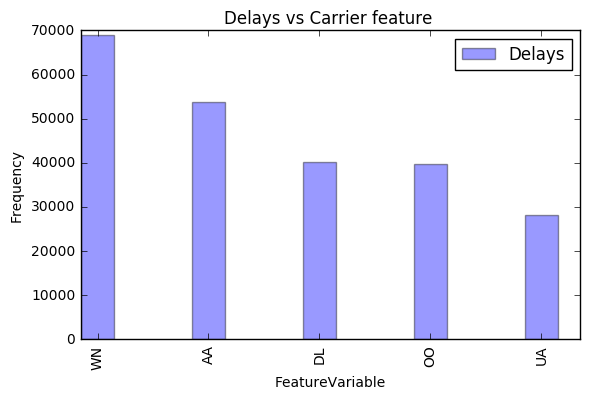

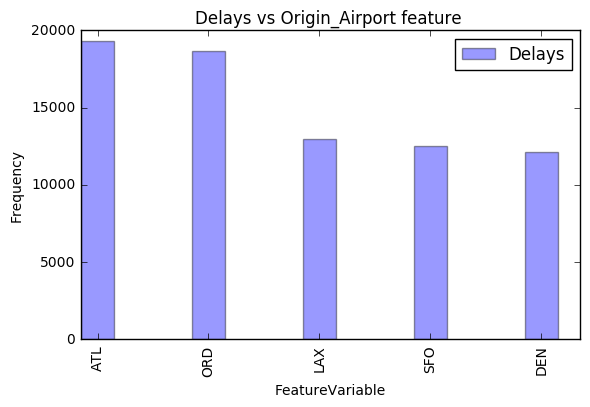

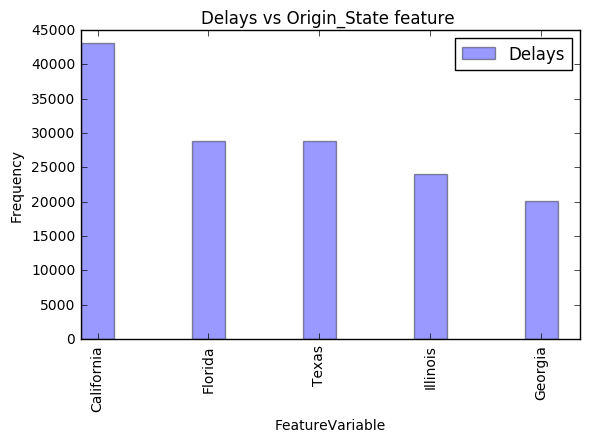

In [33]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#using matplotlib
def varHistograms(table, var, numberofcategories):
    """   
    :param table: target variable frequencies sql table
    :param feature: variable feature
    :param numberofcategories: number of distinct categories in feature
    :return: 
    """
    labels = table[var]
    delaycounts = table['DelayCount']
    n = numberofcategories

    fig, ax = plt.subplots()
    index = np.arange(n)
    bar_width = 0.3

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects = ax.bar(index, delaycounts, bar_width,
                    alpha=opacity, color='b',
                    error_kw=error_config,
                    label='Delays')

    ax.set_xlabel('FeatureVariable')
    ax.set_ylabel('Frequency')
    ax.set_title('Delays vs ' + var + ' feature ')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.xticks(rotation='vertical')
    plt.show()

varHistograms(carriers_table,'Carrier', 5)
varHistograms(airports_table, 'Origin_Airport', 5)
varHistograms(states_table, 'Origin_State', 5)

# Train and Test Model

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow4.png",width=442,height=426>

### 1. Split training and testing data

In [34]:
traindata, testdata = air_df.randomSplit([0.90, 0.10], seed=1234);

### 2. Restructure the data in order to create feature vectors

In [38]:
#Delete the unnecessary columns from data frame
dropcols = ["Dep_delay", "Dep_delay15", "Arr_delay", "Carrier_delay", "Weather_delay", "Nas_delay", "Security_delay", "Lateaircraft_delay"]
traindatafiltered = traindata.select([column for column in traindata.columns if column not in dropcols])
testdatafiltered = testdata.select([column for column in testdata.columns if column not in dropcols])

In [39]:
testdatafiltered.take(3)

[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=0.0), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=1.0)]

In [80]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="Arr_delay15", outputCol="label")

In [81]:
traindatafinal = label_stringIdx.fit(traindatafiltered).transform(traindatafiltered)
testdatafinal = label_stringIdx.fit(testdatafiltered).transform(testdatafiltered)

In [82]:
testdatafinal.take(3)

[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=0.0, label=0.0), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=1.0, label=1.0)]

### 3. ML Pipeline

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
categoricalColumns = ["Carrier", "Origin_Airport", "Origin_State", "Dest_Airport", "Dest_State"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    testfeatureindexer = stringIndexer.fit(testdatafinal).transform(testdatafinal)
    testfeatureindexer.take(1)
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer]

[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0, CarrierIndex=1.0)]
[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0, Origin_AirportIndex=2.0)]
[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0, Origin_StateIndex=5.0)]
[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Flori

In [87]:
# Transform all features into a vector using VectorAssembler
numericCols = ["Year", "Month", "Day", "Day_of_week", "Origin_AirportID", "Dest_AirportID"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [88]:
pipelinetest = Pipeline(stages=stages)
finalfeatures = pipelinetest.fit(testdatafinal).transform(testdatafinal)
finalfeatures.take(3)

[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0, CarrierIndex=1.0, Origin_AirportIndex=2.0, Origin_StateIndex=5.0, Dest_AirportIndex=25.0, Dest_StateIndex=2.0, features=DenseVector([1.0, 2.0, 5.0, 25.0, 2.0, 2016.0, 1.0, 1.0, 5.0, 11292.0, 13303.0])), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=0.0, label=0.0, CarrierIndex=7.0, Origin_AirportIndex=59.0, Origin_StateIndex=26.0, Dest_AirportIndex=9.0, Dest_StateIndex=11.0, features=DenseVector([7.0, 59.0, 26.0, 9.0, 11.0, 2016.0, 1.0, 1.0, 5.0, 10299.0, 14747.0])), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airpor

In [92]:
model = LogisticRegression(featuresCol="features", maxIter=25, regParam=0.01, elasticNetParam=0.5)
LRMstages = stages + [model]
# Create a Pipeline.
pipeline = Pipeline(stages=LRMstages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineLRModel = pipeline.fit(traindatafinal)

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow5.png",width=442,height=426>

### 4. Test the Model

In [93]:
LRMpredictions = pipelineLRModel.transform(testdatafinal)
# Keep relevant columns
LRMpredictions.printSchema()

root
 |-- Year: double (nullable = true)
 |-- Month: double (nullable = true)
 |-- Day: double (nullable = true)
 |-- Day_of_week: double (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- Origin_AirportID: double (nullable = true)
 |-- Origin_Airport: string (nullable = true)
 |-- Origin_State: string (nullable = true)
 |-- Dest_AirportID: double (nullable = true)
 |-- Dest_Airport: string (nullable = true)
 |-- Dest_State: string (nullable = true)
 |-- Arr_delay15: double (nullable = true)
 |-- label: double (nullable = true)
 |-- CarrierIndex: double (nullable = true)
 |-- Origin_AirportIndex: double (nullable = true)
 |-- Origin_StateIndex: double (nullable = true)
 |-- Dest_AirportIndex: double (nullable = true)
 |-- Dest_StateIndex: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)

In [94]:
LRMpredictions.take(3)

[Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', Arr_delay15=0.0, label=0.0, CarrierIndex=1.0, Origin_AirportIndex=2.0, Origin_StateIndex=6.0, Dest_AirportIndex=26.0, Dest_StateIndex=2.0, features=DenseVector([1.0, 2.0, 6.0, 26.0, 2.0, 2016.0, 1.0, 1.0, 5.0, 11292.0, 13303.0]), rawPrediction=DenseVector([1.6004, -1.6004]), probability=DenseVector([0.8321, 0.1679]), prediction=0.0), Row(Year=2016.0, Month=1.0, Day=1.0, Day_of_week=5.0, Carrier=u'AS', Origin_AirportID=10299.0, Origin_Airport=u'ANC', Origin_State=u'Alaska', Dest_AirportID=14747.0, Dest_Airport=u'SEA', Dest_State=u'Washington', Arr_delay15=0.0, label=0.0, CarrierIndex=7.0, Origin_AirportIndex=60.0, Origin_StateIndex=27.0, Dest_AirportIndex=9.0, Dest_StateIndex=11.0, features=DenseVector([7.0, 60.0, 27.0, 9.0, 11.0, 2016.0, 1.0, 1.0, 5.0, 10299.0, 14747.0]), rawP

In [96]:
accuracytest = LRMpredictions.filter((LRMpredictions.label == LRMpredictions.prediction)).count() / float(LRMpredictions.count())
print("Accuracy = " + str(accuracytest))

Accuracy = 0.832600021568

In [49]:
from pyspark.ml.classification import RandomForestClassifier

RFmodel = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=20, \
                                   maxDepth=6, maxBins=310)
RFstages = stages + [RFmodel]
# Create a Pipeline.
RFpipeline = Pipeline(stages=RFstages)
RFModel = RFpipeline.fit(traindatafiltered)

In [50]:
RFpredictions = RFModel.transform(testdatafiltered)
accuracyrf = RFpredictions.filter((RFpredictions.label == RFpredictions.prediction)).count() / float(RFpredictions.count())
print("Accuracy = " + str(accuracyrf))

Accuracy = 0.832600021568

<img src="https://raw.githubusercontent.com/yujhongmicrosoft/images/master/ml-flow6.png",width=442,height=426>

## Save and Load model

In [98]:
pipelineLRModel.save("wasb:///HdiSamples/HdiSamples/flightdelayfinalmodel")

In [99]:
from pyspark.ml import Pipeline, PipelineModel
lrModel = PipelineModel.load("wasb:///HdiSamples/HdiSamples/flightdelayfinalmodel")

In [105]:
testinginput = [(2016.0, 8.0, 1.0, 5.0, 'AA', 11292.0, 'DEN', 'Colorado', 13303.0, 'MIA', 'Florida')]
testrdd = sc.parallelize(testinginput)
testrdd.take(1)

[(2016.0, 8.0, 1.0, 5.0, 'AA', 11292.0, 'DEN', 'Colorado', 13303.0, 'MIA', 'Florida')]

In [106]:
airtest_categories = StructType([StructField("Year", DoubleType(), True), 
                     StructField("Month", DoubleType(), True), 
                     StructField("Day", DoubleType(), True), 
                     StructField("Day_of_week", DoubleType(), True),
                     StructField("Carrier", StringType(), True),
                     StructField("Origin_AirportID", DoubleType(), True),
                     StructField("Origin_Airport", StringType(), True),
                     StructField("Origin_State", StringType(), True),
                     StructField("Dest_AirportID", DoubleType(), True),
                     StructField("Dest_Airport", StringType(), True),
                     StructField("Dest_State", StringType(), True)])
airtest_df = sqlContext.createDataFrame(testrdd, airtest_categories)

In [107]:
airtest_df.take(1)

[Row(Year=2016.0, Month=8.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida')]

In [108]:
testpreds = lrModel.transform(airtest_df)

In [109]:
testpreds.take(1)

[Row(Year=2016.0, Month=8.0, Day=1.0, Day_of_week=5.0, Carrier=u'AA', Origin_AirportID=11292.0, Origin_Airport=u'DEN', Origin_State=u'Colorado', Dest_AirportID=13303.0, Dest_Airport=u'MIA', Dest_State=u'Florida', CarrierIndex=1.0, Origin_AirportIndex=2.0, Origin_StateIndex=6.0, Dest_AirportIndex=26.0, Dest_StateIndex=2.0, features=DenseVector([1.0, 2.0, 6.0, 26.0, 2.0, 2016.0, 8.0, 1.0, 5.0, 11292.0, 13303.0]), rawPrediction=DenseVector([1.5961, -1.5961]), probability=DenseVector([0.8315, 0.1685]), prediction=0.0)]